In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import prince
import importlib

import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import Patch
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.cm as cm
import matplotlib.patches as mpatches

from networkx.algorithms import bipartite


import community as community_louvain
from netgraph import Graph

import sys
sys.path.insert(0, '../Utility files')
import corg
from corg import DiscoverDimension
import seaborn as sn
from corg import BenchmarkDimension
from corg import DiscoverDimension


import utils2
from utils2 import *
import graphfunk
from graphfunk import *

import ca_pipeline
from ca_pipeline import *


/tmp/ipykernel_1350412/3702154355.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


See this link for setting up the facebook marketing API code:
- https://github.com/carolcoimbra/facebook-ads/blob/master/example.ipynb 

# What Markers to Include?

In this notebook, I'll try to identify what markers that make sense to include in our analysis. 
- We identify the dimension that is best at classifying/separating markers of clear difference in SES.
- We do this via the CORG method for different CA fits (varying the network to include or leave out certain markers)
- The CORG methodology might be problematic since we don't have a good span of data variables in high and low categories

### Create an empty csv file to fill in manualy (High vs. Low SES)

- The data used to create the labeled df contains a row for each follower relationship a brand has. It includes the original type column, as well as the changed column (condensed from 12 to 4 types.)
- Additionally, it has been filtered to only include markers with more than 100 followers

In [ ]:

# # load data
# path = '/home/livtollanes/NewData/french/french_edgelist_marker_threshold.csv'

# req_cols = ['marker_id', 'follower_id', 'twitter_name','followers','french_followers', 'type', 'type2']
# dtypes = {'marker_id': 'object',
#           'follower_id': 'object',
#           'twitter_name': 'object',
#           'followers': 'int64',
#           'french_followers': 'int64',
#           'type': 'object',
#           'type2': 'object'}


# edgelist_CORG = pd.read_csv(path, usecols=req_cols, dtype=dtypes)

# #Separate my data frame into dictionary of types
# def create_dict(df, key_col, value_col):
#     unique_df = df.drop_duplicates(subset=[key_col, value_col])
#     return unique_df.groupby(key_col)[value_col].apply(list).to_dict()


# df_dict = create_dict(edgelist_CORG, 'type', 'twitter_name')
# df_dict2 = create_dict(edgelist_CORG, 'type2', 'twitter_name')


# for key, value in df_dict.items():
#     value = list(set(value))
#     print(f"Key: {key}")
#     print(f"Value: {value}\n")



# # Create a csv file to use for labeling 
# rows = []
# for key, values in df_dict.items():
#     for value in values:
#         row = {'type': key, 'twitter_name': value, 'high': '', 'low': ''}
#         rows.append(row)

# # Now we write the rows to a CSV file
# keys = ['type', 'twitter_name', 'high', 'low']

# with open('/home/livtollanes/10.jan-thesis/labeldata/labeled_markers_empty.csv', 'w', newline='') as output_file:
#     dict_writer = csv.DictWriter(output_file, keys)
#     dict_writer.writeheader()
#     dict_writer.writerows(rows)

### Load filled label data

In [21]:
# load data
path = '/home/livtollanes/10.jan-thesis/labeldata/filled_labels_markers.csv'

req_cols = ['type', 'twitter_name', 'high', 'low', 'other']
dtypes = {'type': 'object',
          'twitter_name': 'object',
          'high': 'object',
          'low': 'object',
          'other': 'object'}

labels_hl = pd.read_csv(path, usecols=req_cols, dtype=dtypes)

Now, reformat the filled in label df

In [22]:
# Create the labeled marker df to input to the CORG method

# Create a copy of labels_hl
labels_CORG = labels_hl.copy()

# Create 'SES' column
labels_CORG['label'] = np.where(labels_CORG['high'] == '1', '1', 
                              np.where(labels_CORG['low'] == '1', '0', 'drop'))

# Drop the rows where 'SES' is 'drop'
labels_CORG = labels_CORG[labels_CORG['label'] != 'drop']

# Keep only 'twitter_name' and 'SES' columns
labels_CORG = labels_CORG[['twitter_name', 'label']]

In [23]:
labels_CORG.head()

,twitter_name,label
5,GilbertLycee,0
7,BurgerKingFR,0
8,McDonaldsFrance,0
13,brioche_doree,0
40,essec,1


In [24]:

# load data
path = '/home/livtollanes/NewData/french/french_edgelist_marker_threshold.csv'

req_cols = ['marker_id', 'follower_id', 'twitter_name','followers','french_followers', 'type', 'type2']
dtypes = {'marker_id': 'object',
          'follower_id': 'object',
          'twitter_name': 'object',
          'followers': 'int64',
          'french_followers': 'int64',
          'type': 'object',
          'type2': 'object'}


all = pd.read_csv(path, usecols=req_cols, dtype=dtypes)


#Include only edges with markers that have been labeled
labeled = all[all['twitter_name'].isin(labels_CORG['twitter_name'])]

#Add the label column
labeled_edgelist = labeled.merge(labels_CORG[['twitter_name', 'label']], on='twitter_name', how='left')

In [27]:

#Add the label column
labeled_edgelist = labeled.merge(labels_CORG[['twitter_name', 'label']], on='twitter_name', how='left')

In [29]:
summary_stats(labeled_edgelist) #This leaves us with 65 745 followers

Shape of DataFrame:  (135832, 8)

Columns in DataFrame:  ['marker_id', 'follower_id', 'twitter_name', 'type', 'followers', 'french_followers', 'type2', 'label']

Data types of columns:
 marker_id           object
follower_id         object
twitter_name        object
type                object
followers            int64
french_followers     int64
type2               object
label               object
dtype: object

Number of unique values in 'follower_id':  65745
Number of duplicate values in 'follower_id':  70087

Number of unique values in 'marker_id':  36
Number of duplicate values in 'marker_id':  135796

Number of missing values in each column:
'marker_id':  0
'follower_id':  0
'twitter_name':  0
'type':  0
'followers':  0
'french_followers':  0
'type2':  0
'label':  0

Number of duplicate rows:  0


In [31]:
labeled_edgelist.head()

,marker_id,follower_id,twitter_name,type,followers,french_followers,type2,label
0,95455794,935523828,lesRepublicains,party,327199,17275,information,1
1,95455794,995300412,lesRepublicains,party,327199,17275,information,1
2,95455794,269956084,lesRepublicains,party,327199,17275,information,1
3,95455794,229047082,lesRepublicains,party,327199,17275,information,1
4,95455794,62083611,lesRepublicains,party,327199,17275,information,1


In [32]:
#Save the labeled edgelist to csv in /home/livtollanes/NewData
labeled_edgelist.to_csv('/home/livtollanes/NewData/french/labeled_edgelist_hl.csv', index=False)

## CORG for assessing models

In [2]:
import corg
from corg import DiscoverDimension
import seaborn as sn
from corg import BenchmarkDimension
from corg import DiscoverDimension


### CORG for full label data

In [3]:


# Define the path to the CSV file
file_path = "/home/livtollanes/NewData/coordinates_labeled_subsets/labeled_markers_coords/labeled_markers_column_coordinates.csv"

# Read the CSV file into a pandas DataFrame
df1 = pd.read_csv(file_path, index_col=0)

# Print the first few rows of the DataFrame
print(df1.head())

           twitter_name  label         0         1         2         3
79471     AUCHAN_France      0  1.241873  0.719329  0.149091 -0.255964
68390      BurgerKingFR      0  1.534309  1.077019  0.940645  0.372392
122437  CasinoEnseignes      0  1.221473  0.726559  0.155903 -0.280529
114850    EDHEC_BSchool      1 -1.060354  1.059938 -0.344198 -0.327015
112006           EMLYON      1 -1.098426  1.091306 -0.397118 -0.343077


In [4]:
df1['label'].value_counts()


label
1    22
0    14
Name: count, dtype: int64

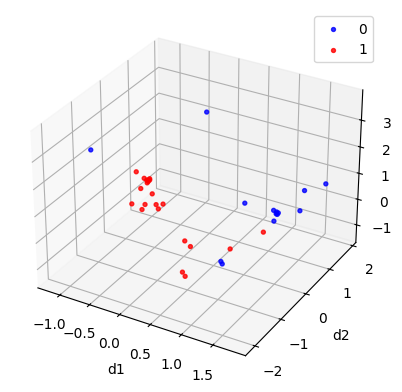

In [7]:
import matplotlib.pyplot as plt

# Define the colors for each label
label_cols = {0: 'blue', 1: 'red'}

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Loop over each unique label in the DataFrame
for label in df1['label'].unique():
    # Select the rows with the current label
    df = df1[df1['label'] == label]
    # Create a scatter plot for the current label
    ax.scatter(df['0'], df['1'], df['2'], alpha=0.8, s=8, c=label_cols[label], label=label)

# Set the labels for the x, y, and z axes
ax.set_xlabel('d1')
ax.set_ylabel('d2')
ax.set_zlabel('d3')

# Show the legend
plt.legend()

# Show the plot
plt.show()

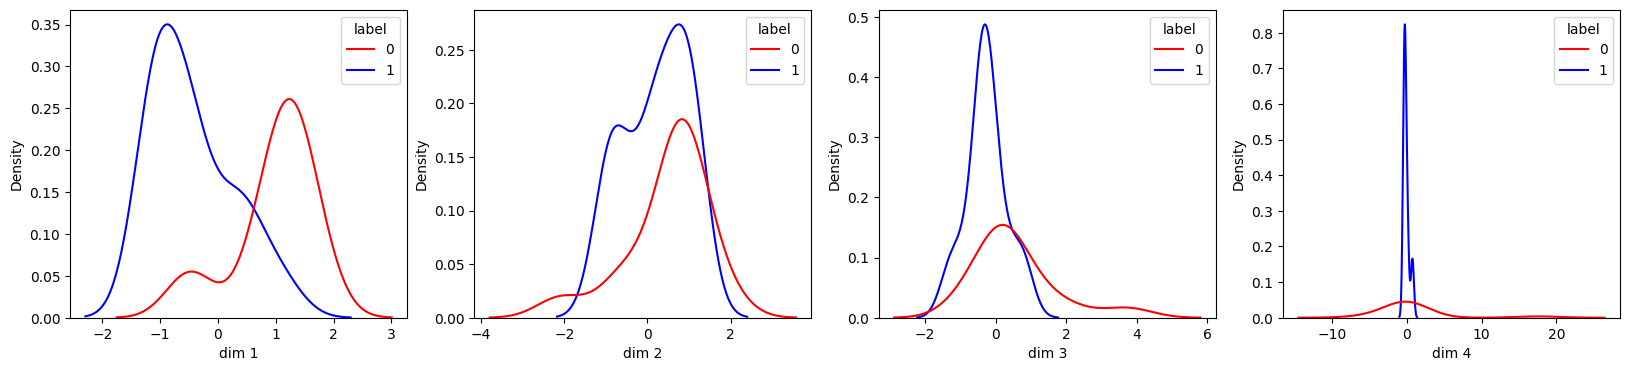

In [10]:
import seaborn as sn
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,4)) # width, height in inches
ax = {1:fig.add_subplot(1,4,1), 2:fig.add_subplot(1,4,2), 3:fig.add_subplot(1,4,3), 4:fig.add_subplot(1,4,4)}

sn.kdeplot(data=df1, x='0', hue='label', ax=ax[1], palette=['red','blue'])
ax[1].set_xlabel('dim 1')

sn.kdeplot(data=df1, x='1', hue='label', ax=ax[2], palette=['red','blue'])
ax[2].set_xlabel('dim 2')

sn.kdeplot(data=df1, x='2', hue='label', ax=ax[3], palette=['red','blue'])
ax[3].set_xlabel('dim 3')

sn.kdeplot(data=df1, x='3', hue='label', ax=ax[4], palette=['red','blue'])
ax[4].set_xlabel('dim 4')

plt.show()

In [13]:
model_d1 = BenchmarkDimension()

from corg import BenchmarkDimension
Y_d1 = df1[['twitter_name','label']].rename(columns={'twitter_name': 'entity'})
X_d1 = df1[['twitter_name','0']].rename(columns={'twitter_name': 'entity'})
model_d1.fit(X_d1, Y_d1)

print('d1: Precision=%.3f, Recall=%.3f, F1-score=%.3f, '%(model_d1.precision_train_,model_d1.recall_train_,model_d1.f1_score_train_))


BenchmarkDimension()

### Spatial dimension

In [15]:
from corg import DiscoverDimension
model = DiscoverDimension()

Y_d1 = df1[['twitter_name','label']].rename(columns={'twitter_name': 'entity'})
X_d1 = df1[['twitter_name','0', '1', '2', '3']].rename(columns={'twitter_name': 'entity'})
model.fit(X_d1, Y_d1)
print(model.model_decision_boundary_)
print(model.decision_hyperplane_unit_normal)


(Text(0.5, 0, '1'), Text(0, 0.5, '2'))

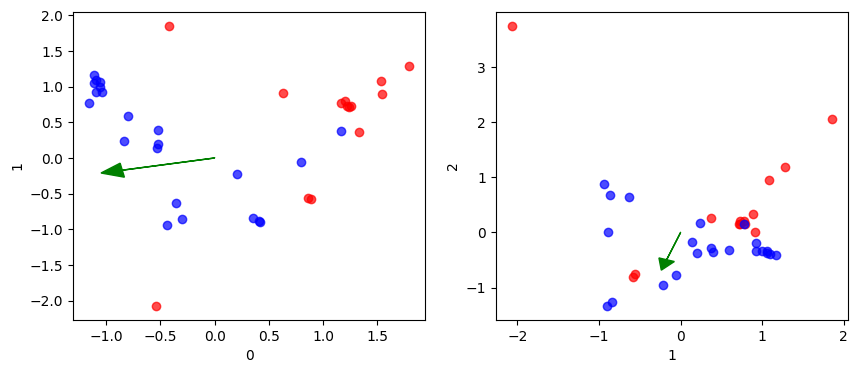

In [25]:
import matplotlib.pyplot as plt

normal = model.decision_hyperplane_unit_normal

fig = plt.figure(figsize=(10,4))
ax = {1:fig.add_subplot(1,2,1),2:fig.add_subplot(1,2,2)}
ax[1].scatter(df1.loc[df1['label'] == 0,'0'],df1.loc[df1['label'] == 0,'1'],alpha=0.7,c='red')
ax[1].scatter(df1.loc[df1['label'] == 1,'0'],df1.loc[df1['label'] == 1,'1'],alpha=0.7,c='blue')
ax[1].arrow(0, 0, normal[0], normal[1],color='green',head_width=0.2,head_length=0.2)
ax[1].set_xlabel('0'),ax[1].set_ylabel('1'),
ax[2].scatter(df1.loc[df1['label'] == 0,'1'],df1.loc[df1['label'] == 0,'2'],alpha=0.7,c='red')
ax[2].scatter(df1.loc[df1['label'] == 1,'1'],df1.loc[df1['label'] == 1,'2'],alpha=0.7,c='blue')
ax[2].arrow(0, 0, normal[1], normal[2],color='green',head_width=0.2,head_length=0.2)
ax[2].set_xlabel('1'),ax[2].set_ylabel('2'),

In [26]:
print('Precision=%.3f, Recall=%.3f, F1-score=%.3f, '%(model.precision_train_,model.recall_train_,model.f1_score_train_))


Precision=0.913, Recall=0.955, F1-score=0.933, 


### Doing it for the commercial one

In [111]:
# Define the path to the CSV file
file_path = "/home/livtollanes/NewData/coordinates_labeled_subsets/labeled_markers_coords/labeled_markers_row_coordinates.csv"

# Read the CSV file into a pandas DataFrame
df1 = pd.read_csv(file_path, index_col=0)

# Print the first few rows of the DataFrame
print(df1.head())

                            0         1         2         3
follower_id                                                
1000005920372518912  1.714780  1.195355  0.812686  0.146717
1000009184577015809 -0.413741 -0.968304  0.891563  0.938862
1000012171395371008  2.026154  1.532228  1.443951  0.617247
1000013161968427015  1.880017  1.408798  1.294287  0.544175
1000014979800748033 -0.344386 -1.025460  0.829003  0.972689


In [103]:
# df1['label'].value_counts()
df1.shape

(10, 6)

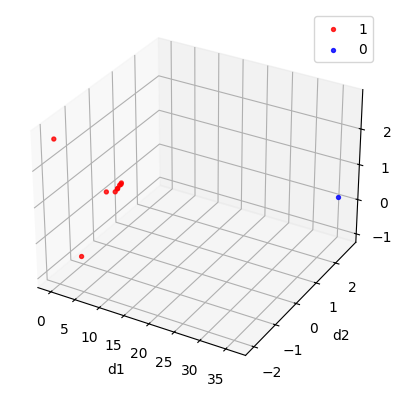

In [104]:
import matplotlib.pyplot as plt

# Define the colors for each label
label_cols = {0: 'blue', 1: 'red'}

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Loop over each unique label in the DataFrame
for label in df1['label'].unique():
    # Select the rows with the current label
    df = df1[df1['label'] == label]
    # Create a scatter plot for the current label
    ax.scatter(df['0'], df['1'], df['2'], alpha=0.8, s=8, c=label_cols[label], label=label)

# Set the labels for the x, y, and z axes
ax.set_xlabel('d1')
ax.set_ylabel('d2')
ax.set_zlabel('d3')

# Show the legend
plt.legend()

# Show the plot
plt.show()

/tmp/ipykernel_1350412/230099625.py:7: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sn.kdeplot(data=df1, x='0', hue='label', ax=ax[1], palette=['red','blue'])
/tmp/ipykernel_1350412/230099625.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sn.kdeplot(data=df1, x='1', hue='label', ax=ax[2], palette=['red','blue'])
/tmp/ipykernel_1350412/230099625.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sn.kdeplot(data=df1, x='2', hue='label', ax=ax[3], palette=['red','blue'])
/tmp/ipykernel_1350412/230099625.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sn.kdeplot(data=df1, x='3', hue='label', ax=ax[4], palette=['red','blue'])


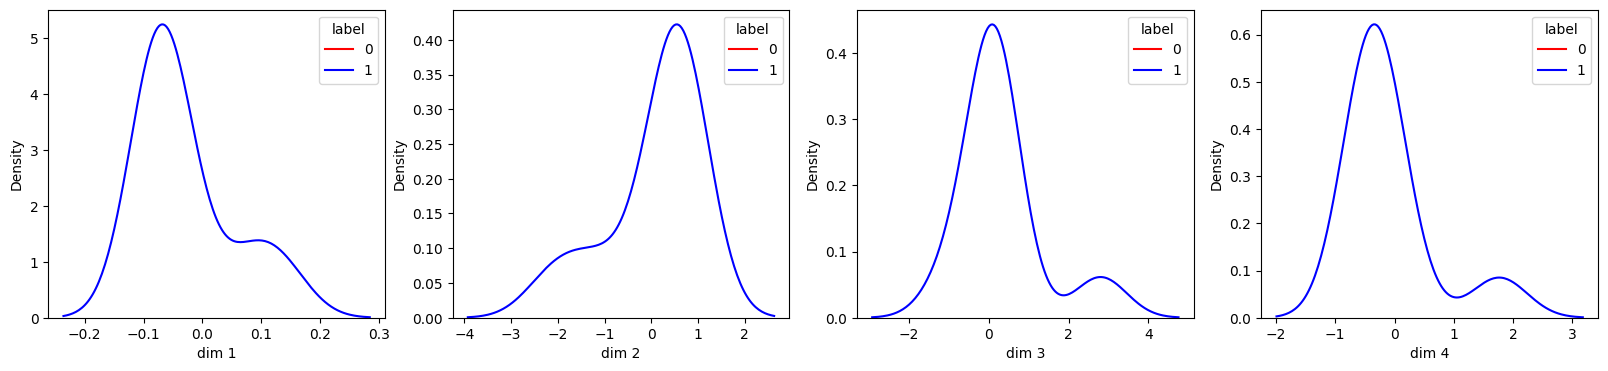

In [106]:
import seaborn as sn
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,4)) # width, height in inches
ax = {1:fig.add_subplot(1,4,1), 2:fig.add_subplot(1,4,2), 3:fig.add_subplot(1,4,3), 4:fig.add_subplot(1,4,4)}

sn.kdeplot(data=df1, x='0', hue='label', ax=ax[1], palette=['red','blue'])
ax[1].set_xlabel('dim 1')

sn.kdeplot(data=df1, x='1', hue='label', ax=ax[2], palette=['red','blue'])
ax[2].set_xlabel('dim 2')

sn.kdeplot(data=df1, x='2', hue='label', ax=ax[3], palette=['red','blue'])
ax[3].set_xlabel('dim 3')

sn.kdeplot(data=df1, x='3', hue='label', ax=ax[4], palette=['red','blue'])
ax[4].set_xlabel('dim 4')

plt.show()

In [107]:
model_d1 = BenchmarkDimension()

from corg import BenchmarkDimension
Y_d1 = df1[['twitter_name','label']].rename(columns={'twitter_name': 'entity'})
X_d1 = df1[['twitter_name','0']].rename(columns={'twitter_name': 'entity'})
model_d1.fit(X_d1, Y_d1)

print('d1: Precision=%.3f, Recall=%.3f, F1-score=%.3f, '%(model_d1.precision_train_,model_d1.recall_train_,model_d1.f1_score_train_))


d1: Precision=1.000, Recall=1.000, F1-score=1.000, 


In [108]:
from corg import DiscoverDimension
model = DiscoverDimension()

Y_d1 = df1[['twitter_name','label']].rename(columns={'twitter_name': 'entity'})
X_d1 = df1[['twitter_name','0', '1', '2', '3']].rename(columns={'twitter_name': 'entity'})
model.fit(X_d1, Y_d1)
print(model.model_decision_boundary_)
print(model.decision_hyperplane_unit_normal)


[-0.32020027694704073, -0.023579648033207955, 0.001234600709465701, -0.0009662100362646933, 6.9155573041828315]
[-0.9972876416888043, -0.0734405722665236, 0.003845255980756118, -0.003009333213668151]


(Text(0.5, 0, '1'), Text(0, 0.5, '2'))

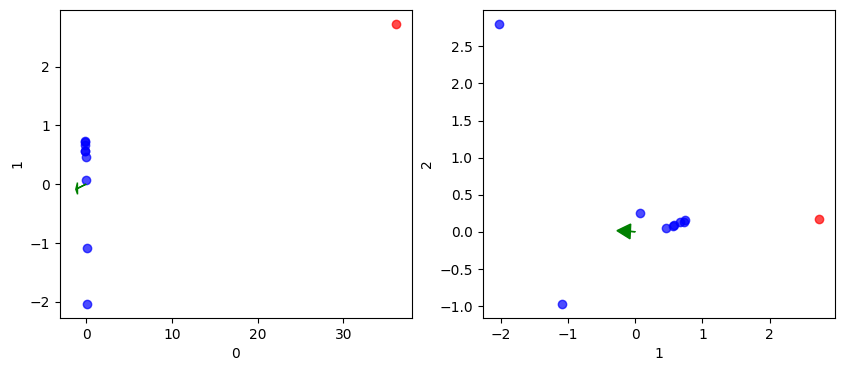

In [109]:
import matplotlib.pyplot as plt

normal = model.decision_hyperplane_unit_normal

fig = plt.figure(figsize=(10,4))
ax = {1:fig.add_subplot(1,2,1),2:fig.add_subplot(1,2,2)}
ax[1].scatter(df1.loc[df1['label'] == 0,'0'],df1.loc[df1['label'] == 0,'1'],alpha=0.7,c='red')
ax[1].scatter(df1.loc[df1['label'] == 1,'0'],df1.loc[df1['label'] == 1,'1'],alpha=0.7,c='blue')
ax[1].arrow(0, 0, normal[0], normal[1],color='green',head_width=0.2,head_length=0.2)
ax[1].set_xlabel('0'),ax[1].set_ylabel('1'),
ax[2].scatter(df1.loc[df1['label'] == 0,'1'],df1.loc[df1['label'] == 0,'2'],alpha=0.7,c='red')
ax[2].scatter(df1.loc[df1['label'] == 1,'1'],df1.loc[df1['label'] == 1,'2'],alpha=0.7,c='blue')
ax[2].arrow(0, 0, normal[1], normal[2],color='green',head_width=0.2,head_length=0.2)
ax[2].set_xlabel('1'),ax[2].set_ylabel('2'),

In [110]:
print('Precision=%.3f, Recall=%.3f, F1-score=%.3f, '%(model.precision_train_,model.recall_train_,model.f1_score_train_))


Precision=1.000, Recall=1.000, F1-score=1.000, 
